In [1]:
#tabular data imports :
import pandas as pd
import numpy as np
from pydataset import data

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# success metrics from earlier in the week: mean squared error and r^2 explained variance
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

#stats
from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import os
directory = os.getcwd()
pd.set_option('display.max_columns', None)

In [2]:
# Calling the function that combines all the steps before and creates a .csv file from the df (to run faster and locally)
df = w.prepare_wine(w.red_wine_url, w.white_wine_url)
df.head(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,quality_category
wine_id,,,,,,,,,,,,,,
w-1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,Average
w-2,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,Average
w-3,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,Average


# UNIVARIATE EXPLORATION

Distribution of fixed_acidity


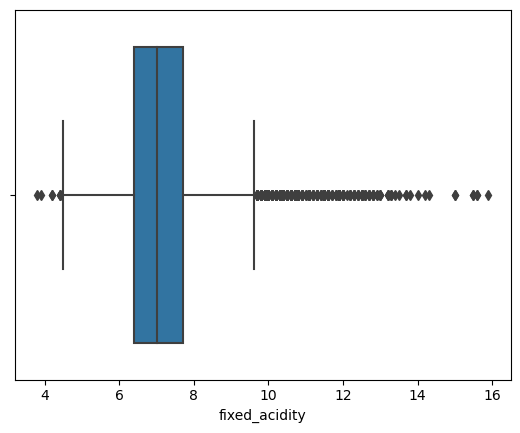

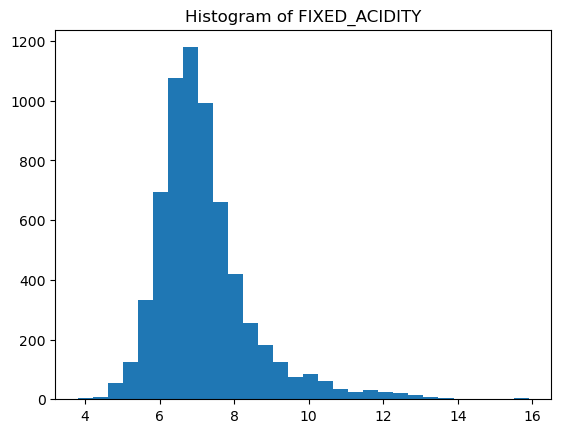

count    6497.000000
mean        7.215307
std         1.296434
min         3.800000
25%         6.400000
50%         7.000000
75%         7.700000
max        15.900000
Name: fixed_acidity, dtype: float64
Distribution of volatile_acidity


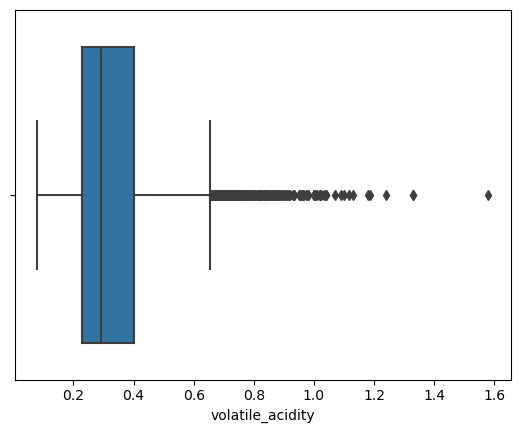

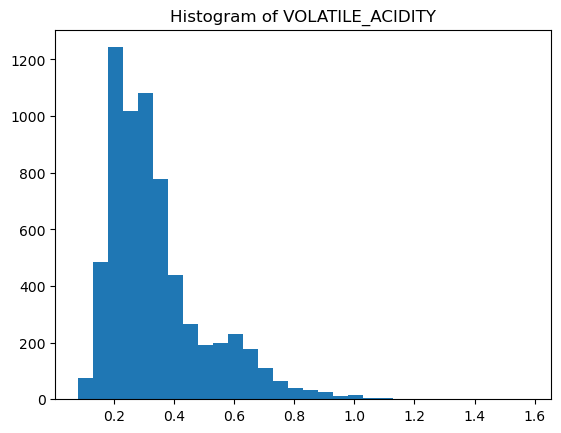

count    6497.000000
mean        0.339666
std         0.164636
min         0.080000
25%         0.230000
50%         0.290000
75%         0.400000
max         1.580000
Name: volatile_acidity, dtype: float64
Distribution of citric_acid


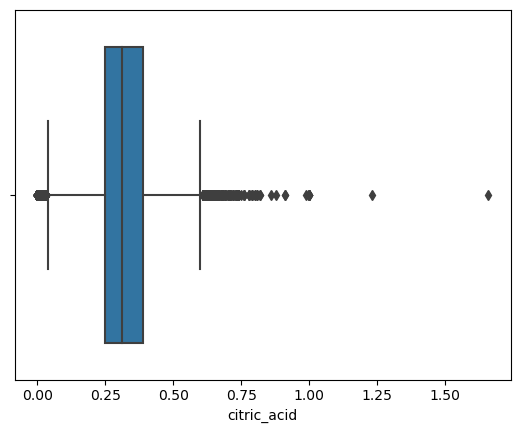

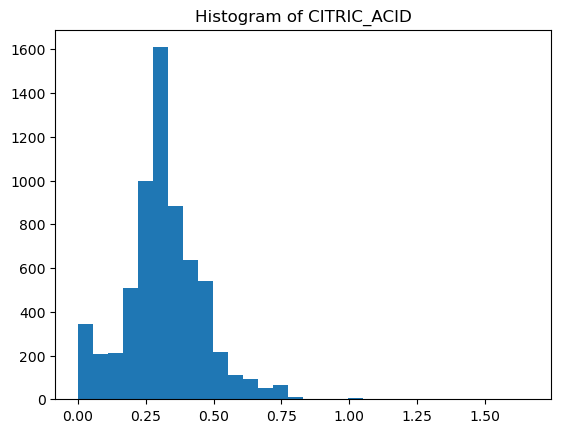

count    6497.000000
mean        0.318633
std         0.145318
min         0.000000
25%         0.250000
50%         0.310000
75%         0.390000
max         1.660000
Name: citric_acid, dtype: float64
Distribution of residual_sugar


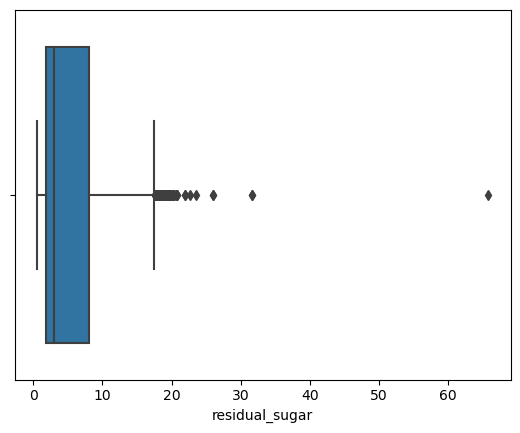

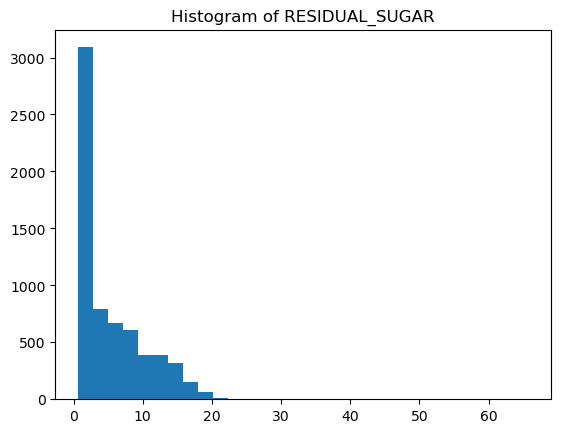

count    6497.000000
mean        5.443235
std         4.757804
min         0.600000
25%         1.800000
50%         3.000000
75%         8.100000
max        65.800000
Name: residual_sugar, dtype: float64
Distribution of chlorides


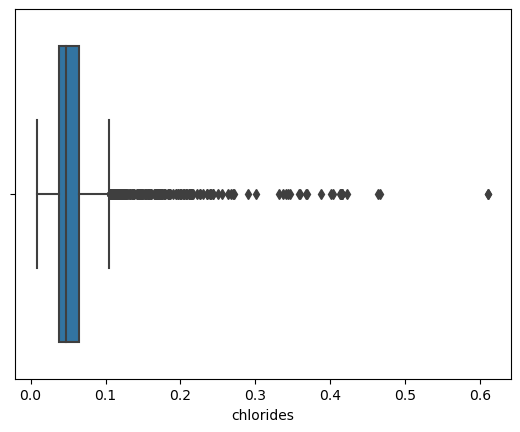

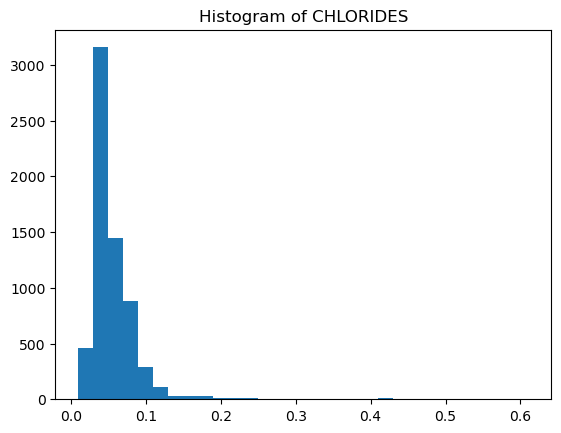

count    6497.000000
mean        0.056034
std         0.035034
min         0.009000
25%         0.038000
50%         0.047000
75%         0.065000
max         0.611000
Name: chlorides, dtype: float64
Distribution of free_sulfur_dioxide


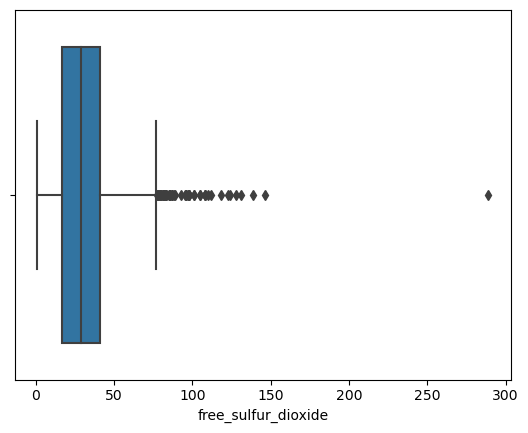

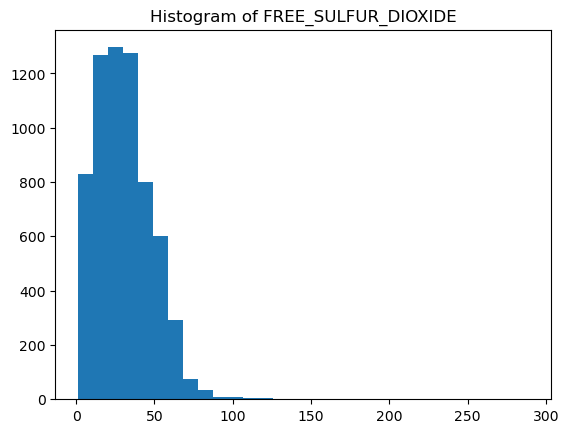

count    6497.000000
mean       30.525319
std        17.749400
min         1.000000
25%        17.000000
50%        29.000000
75%        41.000000
max       289.000000
Name: free_sulfur_dioxide, dtype: float64
Distribution of total_sulfur_dioxide


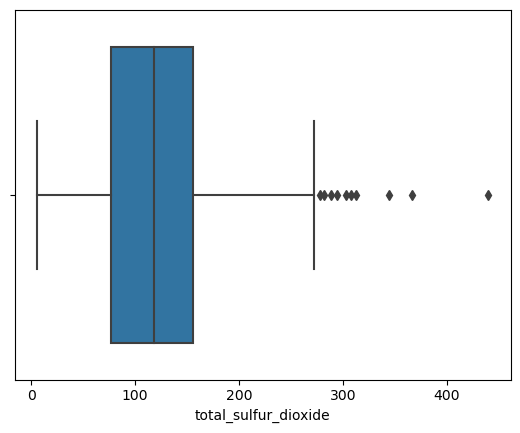

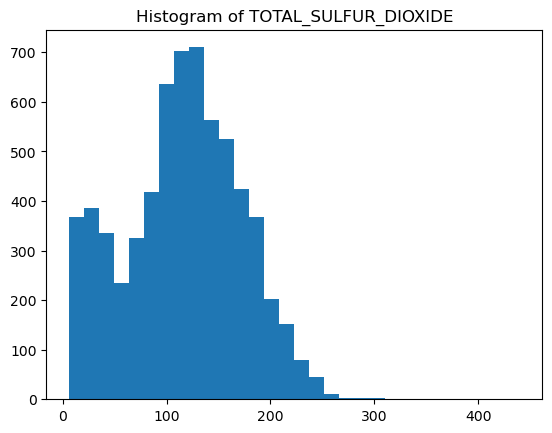

count    6497.000000
mean      115.744574
std        56.521855
min         6.000000
25%        77.000000
50%       118.000000
75%       156.000000
max       440.000000
Name: total_sulfur_dioxide, dtype: float64
Distribution of density


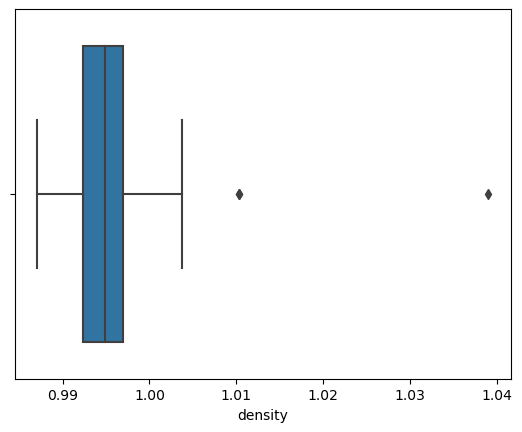

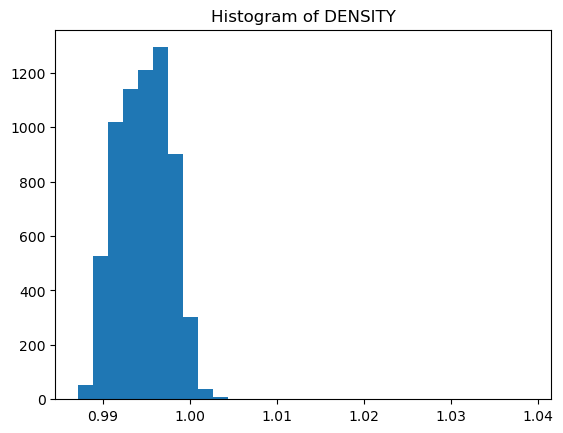

count    6497.000000
mean        0.994697
std         0.002999
min         0.987110
25%         0.992340
50%         0.994890
75%         0.996990
max         1.038980
Name: density, dtype: float64
Distribution of pH


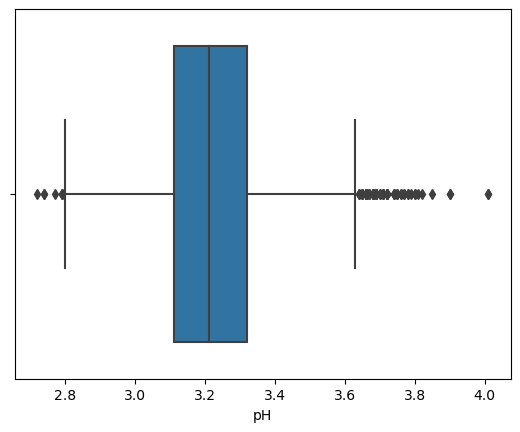

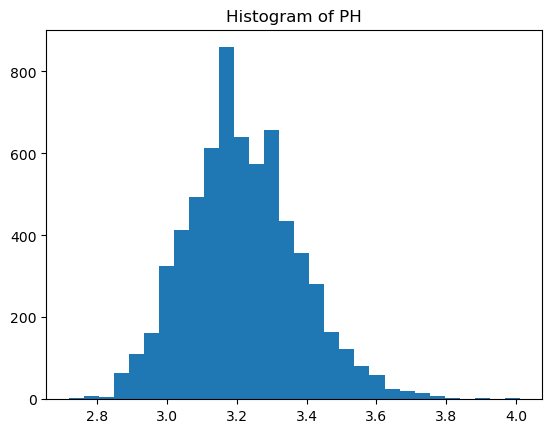

count    6497.000000
mean        3.218501
std         0.160787
min         2.720000
25%         3.110000
50%         3.210000
75%         3.320000
max         4.010000
Name: pH, dtype: float64
Distribution of sulphates


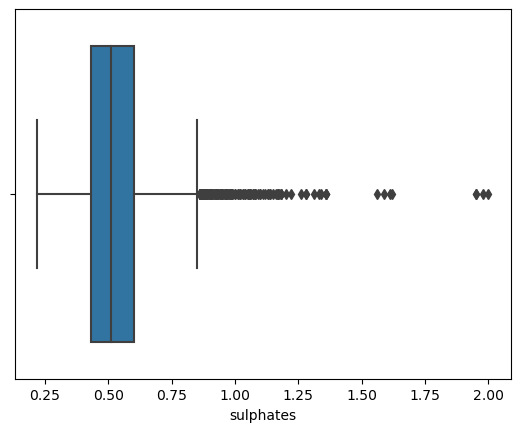

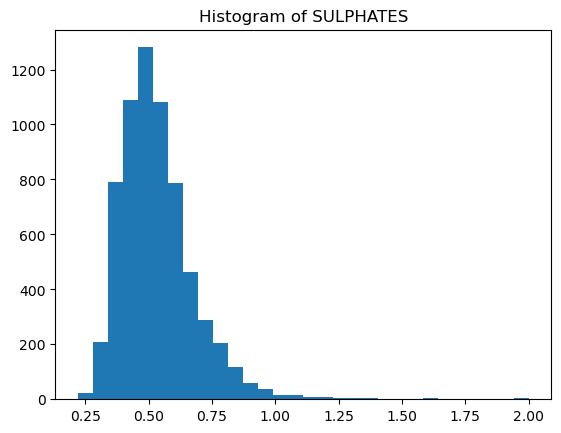

count    6497.000000
mean        0.531268
std         0.148806
min         0.220000
25%         0.430000
50%         0.510000
75%         0.600000
max         2.000000
Name: sulphates, dtype: float64
Distribution of alcohol


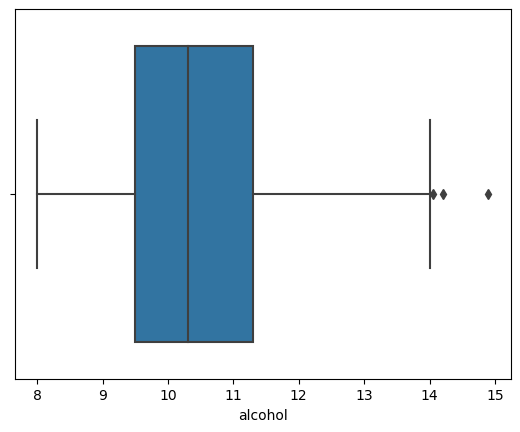

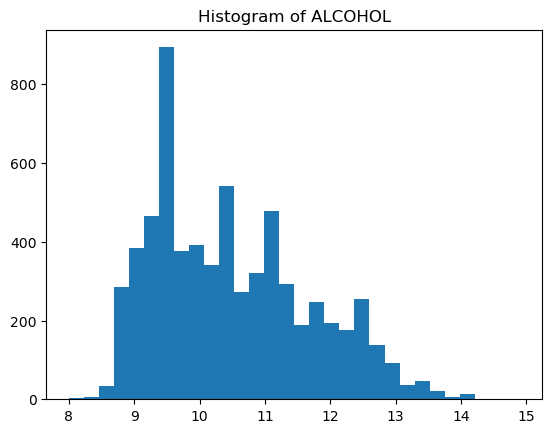

count    6497.000000
mean       10.491801
std         1.192712
min         8.000000
25%         9.500000
50%        10.300000
75%        11.300000
max        14.900000
Name: alcohol, dtype: float64
Distribution of quality


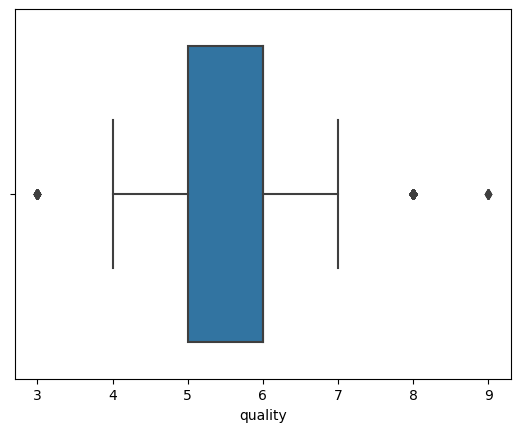

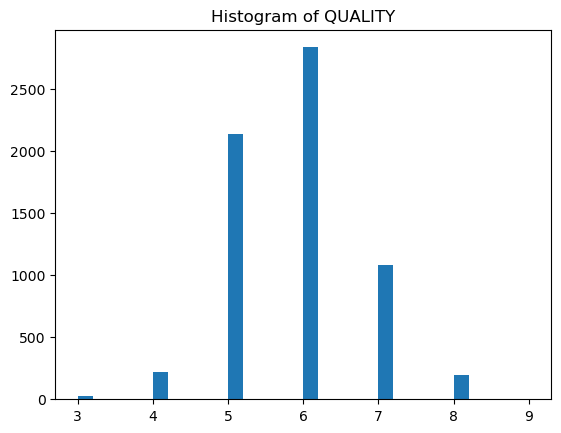

count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64


In [4]:
for col in df.columns:
    # Skip the 'quality_category' column
    if col in ['quality_category','color']:
        continue

    # Print out a report header with the column name
    print(f'Distribution of {col}')

    # Present a box plot of the information
    sns.boxplot(data=df, x=col)
    plt.show()

    # Present a histogram
    plt.hist(df[col].dropna(), bins=30)  # dropna() to handle NaN values, and you can adjust bins as needed
    plt.title(f'Histogram of {col.upper()}')
    plt.show()

    # Print descriptive statistics
    print(df[col].describe())

    print('===================')

In [6]:
# comparing the numbers of wine
pd.crosstab(df.color, df.quality_category)

quality_category,Average,High,Low
color,,,
red,1518,18,63
white,4535,180,183
